FORECASTING DE CSAT SCORE SEMANAL PARA PREDECIR EL POSIBLE COMPORTAMIENTO PARA 10 SEMANAS EMPLEANDO SARIMA

(Modelo para insertar en Power BI)

In [4]:
### LIBRERÍAS

import numpy as np
import pandas as pd

import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")
from datetime import datetime
import seaborn as sns

In [5]:
### FUENTE DE DATOS Y PREPARACION DE LOS DATOS

ruta = "C:/Users/joey_/Desktop/DESK 2025/DB (RESPALDOS)/CSAT.xlsx"
df = pd.read_excel(ruta, sheet_name="Sheet1")

df["Start of Week"] = pd.to_datetime(df["Start of Week"])
df = df.rename(columns={"% CSAT (LOOKER)": "CSAT"})
df = df.rename(columns={"Start of Week": "Semana"})
df = df.drop("ID", axis=1)

df.tail(3)

,WEEK,Semana,CSAT
42,51,2023-12-17,0.706587
43,52,2023-12-24,0.714286
44,53,2023-12-31,0.684211


In [6]:
### SPLITEO DE DATOS

# Dividir los datos en entrenamiento y prueba
train_size = int(len(df) * 0.6)
train, test = df.iloc[:train_size], df.iloc[train_size:]

print(f"Entrenamiento: {len(train)} semanas")
print(f"Prueba: {len(test)} semanas")

Entrenamiento: 27 semanas
Prueba: 18 semanas


In [7]:
### TRENDING (VALORES ACTUALES)

fig = px.line(df, x="Semana", y="CSAT",template = "plotly_dark",
              title="CSAT Score by Week")
fig.show()

In [8]:
### PRUEBA DE ESTACIONARIEDAD (DICKEY-FULLER)

from statsmodels.tsa.stattools import adfuller
import pandas as pd

def Prueba_Dickey_Fuller(series, column_name):
    print(f'Resultados de la prueba de Dickey-Fuller para columna: {column_name}')
    
    # Realizar la prueba de Dickey-Fuller
    dftest = adfuller(series, autolag='AIC')
    
    # Crear una serie de pandas con los resultados principales
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'No Lags Used', 'Número de observaciones utilizadas'])
    
    # Agregar los valores críticos al resultado
    for key, value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value
    
    # Mostrar los resultados
    print(dfoutput)
    
    # Interpretar los resultados
    if dftest[1] <= 0.05:
        print("Conclusión:====>")
        print("Rechazar la hipótesis nula")
        print("Los datos son estacionarios")
    else:
        print("Conclusión:====>")
        print("No se puede rechazar la hipótesis nula")
        print("Los datos no son estacionarios")

Prueba_Dickey_Fuller(df["CSAT"],"CSAT")

Resultados de la prueba de Dickey-Fuller para columna: CSAT
Test Statistic                        -5.231839
p-value                                0.000008
No Lags Used                           0.000000
Número de observaciones utilizadas    44.000000
Critical Value (1%)                   -3.588573
Critical Value (5%)                   -2.929886
Critical Value (10%)                  -2.603185
dtype: float64
Conclusión:====>
Rechazar la hipótesis nula
Los datos son estacionarios


In [9]:
### DATOS CON DIFFERENCING (SI ES NECESARIO)

df1=df.copy()
# Take first difference
df1['CSAT'] = df['CSAT'].diff()

# Remove the first data point
df1.dropna(inplace=True)

# Take a look at the head of the dataset
df1.head()


,WEEK,Semana,CSAT
1,10,2023-03-05,0.001923
2,11,2023-03-12,-0.046005
3,12,2023-03-19,0.052889
4,13,2023-03-26,-0.025060
5,14,2023-04-02,-0.033808


In [10]:
### TRENDING (DIFFERENCING)

fig = px.line(df1, x="Semana", y="CSAT",template = "plotly_dark",
              title="CSAT Score difference by Week")
fig.show()

In [11]:
### PRUEBA DE ESTACIONARIEDAD (DICKEY-FULLER) CON DIFFERENCING

Prueba_Dickey_Fuller(df1["CSAT"],"CSAT")

Resultados de la prueba de Dickey-Fuller para columna: CSAT
Test Statistic                       -1.262760e+01
p-value                               1.529484e-23
No Lags Used                          0.000000e+00
Número de observaciones utilizadas    4.300000e+01
Critical Value (1%)                  -3.592504e+00
Critical Value (5%)                  -2.931550e+00
Critical Value (10%)                 -2.604066e+00
dtype: float64
Conclusión:====>
Rechazar la hipótesis nula
Los datos son estacionarios


In [12]:
### DESCOMPOSICIÓN DE SERIES TEMPORALES

plt.rcParams["figure.figsize"] = (12, 8)

# Descomposición de la serie temporal
decomposition = seasonal_decompose(df['CSAT'], model='additive', period=4)


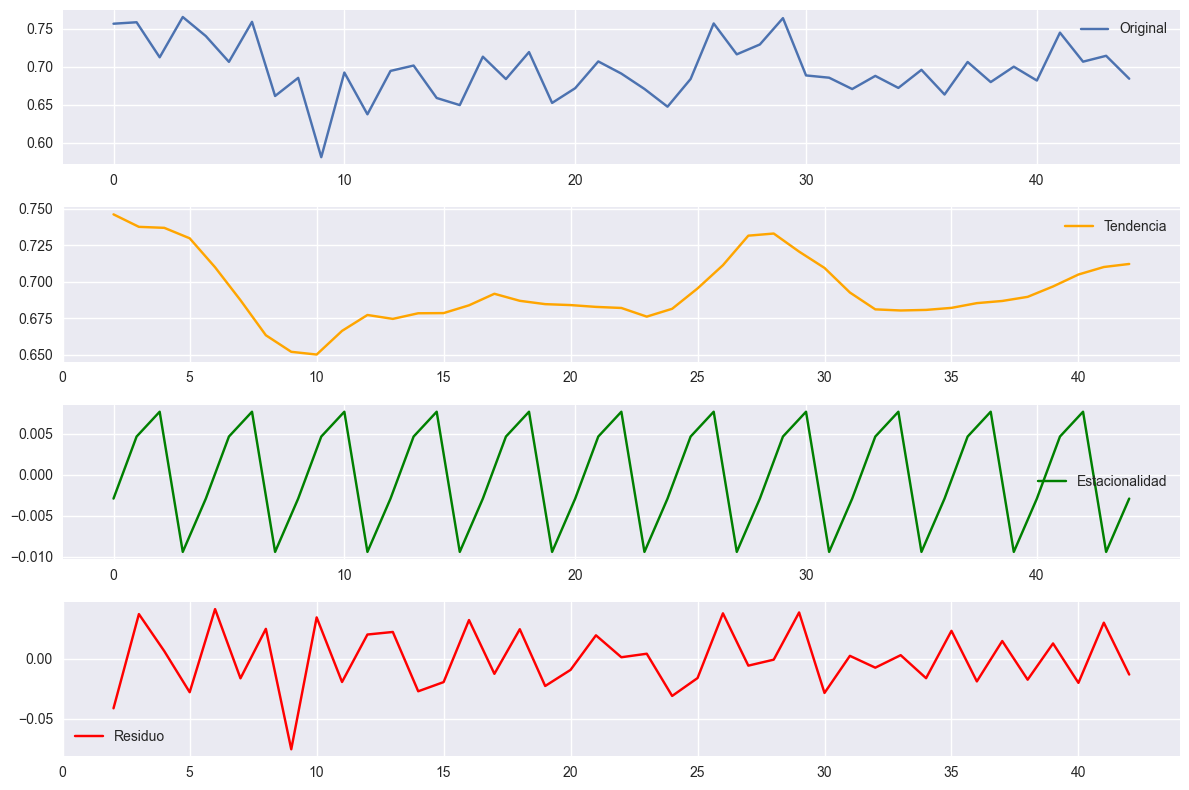

In [13]:
### VISUALIZACIÓN DE LA DESCOMPOSICIÓN

# Componentes de la descomposición
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Crear una figura con subplots
plt.figure(figsize=(12, 8))
plt.style.use('seaborn-v0_8')

# Gráfico de la serie original
plt.subplot(4, 1, 1)
plt.plot(df['CSAT'], label='Original')
plt.legend()

# Gráfico de la tendencia
plt.subplot(4, 1, 2)
plt.plot(trend, label='Tendencia', color='orange')
plt.legend()

# Gráfico de la estacionalidad
plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Estacionalidad', color='green')
plt.legend()

# Gráfico del residuo
plt.subplot(4, 1, 4)
plt.plot(residual, label='Residuo', color='red')
plt.legend()

# Ajustar el espacio entre subplots
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [14]:
### MODELO AUTO-ARIMA

from pmdarima import auto_arima   

modelo_auto=auto_arima(train["CSAT"],start_p=0,d=1,start_q=0,
          max_p=4,max_d=2,max_q=4, start_P=0,
          D=1, start_Q=0, max_P=2,max_D=1,
          max_Q=2, m=4, seasonal=True,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=20,n_fits=50)
print(modelo_auto)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=-50.836, Time=0.52 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=-59.595, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=-62.498, Time=0.36 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=-58.987, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[4]             : AIC=-60.502, Time=0.36 sec
 ARIMA(0,1,1)(0,1,2)[4]             : AIC=-60.503, Time=0.29 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=-60.291, Time=0.26 sec
 ARIMA(0,1,1)(1,1,2)[4]             : AIC=inf, Time=0.52 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=-56.986, Time=0.14 sec
 ARIMA(1,1,1)(0,1,1)[4]             : AIC=-60.827, Time=0.40 sec
 ARIMA(0,1,2)(0,1,1)[4]             : AIC=-60.800, Time=0.29 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=-61.720, Time=0.49 sec
 ARIMA(1,1,2)(0,1,1)[4]             : AIC=-58.853, Time=0.40 sec
 ARIMA(0,1,1)(0,1,1)[4] intercept   : AIC=inf, Time=0.41 sec

Best model:  ARIMA(0,1,1)(0,1,1)[4]          
Total fi

In [15]:
### MODELO SARIMA CON LOS MEJORES PARÁMETROS

model = SARIMAX(df['CSAT'], order=(0, 1, 1), seasonal_order=(0, 1, 1, 4))
model_fit = model.fit()
print(model_fit.summary())


                                     SARIMAX Results                                     
Dep. Variable:                              CSAT   No. Observations:                   45
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 4)   Log Likelihood                  69.559
Date:                           Wed, 19 Mar 2025   AIC                           -133.118
Time:                                   16:48:58   BIC                           -128.052
Sample:                                        0   HQIC                          -131.286
                                            - 45                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6103      0.139     -4.403      0.000      -0.882      -0.339
ma.S.L4       -0.7528      0.222     -3.391

In [16]:
### PRECISIÓN DEL MODELO

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Realizar predicciones en el conjunto de prueba
predictions = model_fit.forecast(steps=len(test))

# Calcular MAE y RMSE
mae = mean_absolute_error(test['CSAT'], predictions)
rmse = np.sqrt(mean_squared_error(test['CSAT'], predictions))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 0.025311777555242547
RMSE: 0.029311110594200895


In [17]:
### PREDICCIÓN DEL MODELO PARA LAS PRÓXIMAS 10 SEMANAS

import plotly.express as px
import plotly.graph_objects as go

# Realizar predicciones para las próximas 10 semanas
future_predictions = model_fit.forecast(steps=10)


# Realizar predicciones para las próximas 10 semanas con intervalo de confianza del 95%
forecast_result = model_fit.get_forecast(steps=10)
future_predictions = forecast_result.predicted_mean


confidence_intervals = forecast_result.conf_int(alpha=0.05)  # 95% IC

# Crear un DataFrame con las predicciones y los intervalos de confianza
future_dates = pd.date_range(max(df["Semana"]), periods=11, freq='W')[1:]
future_df = pd.DataFrame({
    'Semana': future_dates,
    'CSAT': future_predictions,
    'Lower CI': confidence_intervals.iloc[:, 0],
    'Upper CI': confidence_intervals.iloc[:, 1]
})


# Combinar los datos originales con las predicciones
combined_df = pd.concat([df, future_df])
combined_df.tail(3)

,WEEK,Semana,CSAT,Lower CI,Upper CI
52,NaN,2024-02-25,0.694633,0.567503,0.821763
53,NaN,2024-03-03,0.726678,0.586861,0.866494
54,NaN,2024-03-10,0.710805,0.563559,0.858051


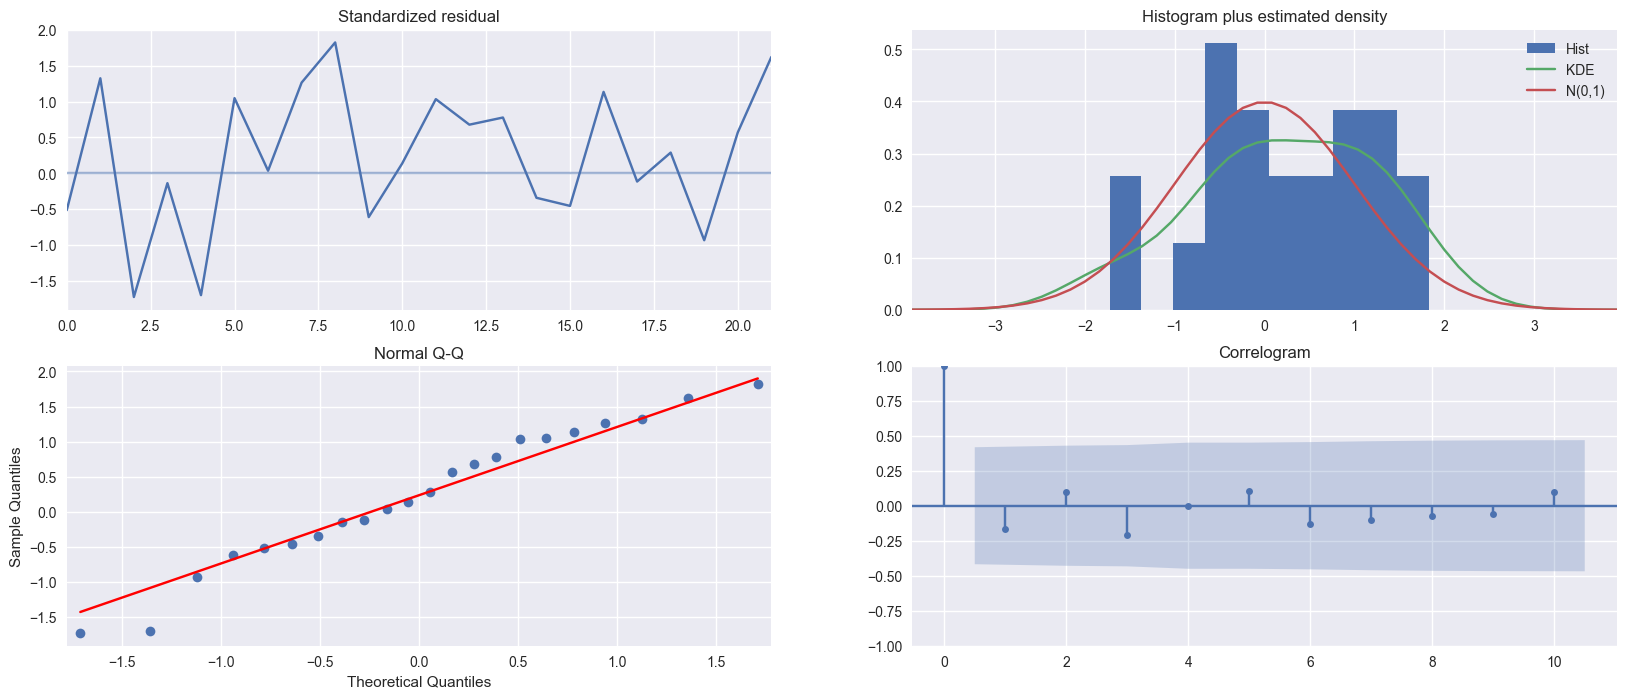

In [18]:
### COMPORTAMIENTO DE LA PREDICCIÓN

plt.style.use('seaborn-v0_8')
modelo_auto.plot_diagnostics(figsize=(20,8))
plt.show()

In [19]:
### PREDICCONES PARA EL PERIODO ACTUAL

sarima_pred = model_fit.predict(start=min(df["WEEK"]),end=max(df["WEEK"]), typ="levels").rename("SARIMA Predictions")

sarima_pred_df = pd.DataFrame(sarima_pred)
sarima_pred_df =  sarima_pred_df.reset_index().rename(columns={'index': 'WEEK'})
sarima_pred_df.head(3)

,WEEK,SARIMA Predictions
0,9,0.672209
1,10,0.637329
2,11,0.634607


In [20]:
### RESULTADO DE LAS PREDICCIONES, VALORES REALES Y INTERVALOS DE CONFIANZA

combined_df2 =   pd.concat([combined_df, sarima_pred_df], axis=1)
combined_df2.head(3)

,WEEK,Semana,CSAT,Lower CI,Upper CI,WEEK,SARIMA Predictions
0,9.0,2023-02-26,0.756410,NaN,NaN,9.0,0.672209
1,10.0,2023-03-05,0.758333,NaN,NaN,10.0,0.637329
2,11.0,2023-03-12,0.712329,NaN,NaN,11.0,0.634607


In [21]:
### VISUALIZACIÓN DE LAS PREDICCIONES, VALORES REALES Y INTERVALOS DE CONFIANZA

import plotly.graph_objects as go

# Crear la figura
fig = go.Figure()

# Agregar los valores históricos
fig.add_trace(go.Scatter(
    x=combined_df2["Semana"],
    y=combined_df2['CSAT'],
    mode='lines',
    name='CSAT Histórico',
    line=dict(color='blue')
))

# Agregar los valores predichos para los datos históricos
fig.add_trace(go.Scatter(
    x=combined_df2["Semana"],
    y=combined_df2['SARIMA Predictions'],
    mode='lines',
    name='CSAT Predicho (Actual)',
    line=dict(color='green', dash='dash')
))

# Agregar las predicciones futuras
fig.add_trace(go.Scatter(
    x=combined_df2["Semana"].tail(10),
    y=combined_df2['CSAT'].tail(10),
    mode='lines',
    name='CSAT Predicho (Futuro)',
    line=dict(color='red')
))

# Agregar el intervalo de confianza del 95%
fig.add_trace(go.Scatter(
    x=combined_df2["Semana"],
    y=combined_df2['Upper CI'],
    mode='lines',
    name='Límite Superior (95% IC)',
    line=dict(color='gray', width=0.5)
))
fig.add_trace(go.Scatter(
    x=combined_df2["Semana"],
    y=combined_df2['Lower CI'],
    mode='lines',
    name='Límite Inferior (95% IC)',
    line=dict(color='gray', width=0.5),
    fill='tonexty',  # Rellenar el área entre los límites superior e inferior
    fillcolor='rgba(200, 100, 200, 0.1)'
))

# Personalizar el gráfico
fig.update_layout(
    title='Predicción del CSAT Score utilizando SARIMA con Intervalo de Confianza del 95%',
    xaxis_title='Fecha',
    yaxis_title='CSAT Score',
    hovermode='x unified',
    template = "plotly_dark",
    width=1100, height=480,
    legend=dict(
        orientation="h",
        y=-0.3,
        x=0.5,
        xanchor="center"
    ),
    showlegend=True
)

# Mostrar el gráfico
fig.show()